In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import modelbase


from scipy.integrate import trapezoid
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from modelbase.ode import mca
from matplotlib.colors import TwoSlopeNorm

def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax


def get_avg(s: Simulator, t_end: float) -> Tuple[pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    vavg = pd.Series(
        trapezoid(v.loc[t_end * 0.75 :, :], x=v.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=v.columns,
    )

    cavg = pd.Series(
        trapezoid(c.loc[t_end * 0.75 :, :], x=c.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=c.columns,
    )

    return cavg.T, vavg.T




In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax

y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}



In [5]:
def plot_concentration_steady_state(
    c1: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c1["ATP"].plot(ax=ax1, label="ATP", color="C0")
    c1["NADP"].plot(ax=ax1, label="NADPH", color="C1")
    c1["Fd"].plot(ax=ax1, label="reduced Fd", color="C2")
    c1["PQ"].plot(ax=ax1, label="reduced PQ", color="C4")
    c1["PC"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="concentration/mM")
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(c1["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("concentration at different lightintensities")
    
    return ax1, ax2

def plot_kNDH1_concentration_steady_state(
    c1: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c1["ATP"].plot(ax=ax1, label="ATP", color="C0")
    c1["NADP"].plot(ax=ax1, label="NADPH", color="C1")
    c1["Fd"].plot(ax=ax1, label="reduced Fd", color="C2")
    c1["PQ"].plot(ax=ax1, label="reduced PQ", color="C4")
    c1["PC"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="kNDH1", ylabel="concentration/mM")
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(c1["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("kNDH1")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("concentration at different lightintensities")
    
    return ax1, ax2

def plot_ppfd_redox_steady_state(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(c["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("energy and redox status")
    return ax1, ax2

def plot_kNDH1_redox_steady_state(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="kNDH1", ylabel="Fraction of the pool")
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(c["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("kNDH1")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("energy and redox status")
    return ax1, ax2

def plot_ppfd_petc_steady_state(
    v: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    (v["vNDH1"]).plot(ax=ax1, label="NDH1")
    (v["vATPsynthase"]).plot(ax=ax1, label="ATPsyn")
    (v["vRuBisCO"]/m.get_parameter("convf")).plot(ax=ax1, label ="RuBisCo")
    ax1.set(
        title="photosynthetic electron fluxes",
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax1.legend(loc="upper left", borderaxespad=0.5)

    ax2.plot(v["vMehler"], "r--", label="Mehler")
    ax2.plot(v["vPTOX"], "r.", label="PTOX")
    ax2.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("mmol e$^-$/mol Chl/s", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    return ax1, ax2

def plot_ppfd_proton_steady_state(
    v: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    (v["vPS2"] * 2).plot(ax=ax1, label="PS2")
    (v["vNDH1"]).plot(ax=ax1, label="NDH1")
    (v["vB6f"]).plot(ax=ax1, label="B6f")
    (v["vATPsynthase"]).plot(ax=ax1, label="ATPsyn")
    (v["vLeak"]).plot(ax=ax1, label ="Leak")
    ax1.set(
        title="photosynthetic proton fluxes",
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax1.legend(loc="upper left", borderaxespad=0.5)

    return ax1, ax2

def plot_kNDH1_petc_steady_state(
    v: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    (v["vNDH1"]).plot(ax=ax1, label="NDH1")
    (v["vATPsynthase"]).plot(ax=ax1, label="ATPsyn")
    (v["vRuBisCO"]/m.get_parameter("convf")).plot(ax=ax1, label ="RuBisCo")
    ax1.set(
        title="photosynthetic electron fluxes",
        xlabel="kNDH1",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax1.legend(loc="upper left", borderaxespad=0.5)

    ax2.plot(v["vMehler"], "r--", label="Mehler")
    ax2.plot(v["vPTOX"], "r.", label="PTOX")
    ax2.set(xlabel="kNDH1")
    ax2.set_ylabel("mmol e$^-$/mol Chl/s", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    return ax1, ax2


def plot_ppfd_pH_and_KeqNDH1(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    c["pH"].plot(ax=ax1, label="pH")
    ax1.set(
        title="pH and Delta G change for different light intensities",
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="pH",
    )
    ax1.legend(loc="lower left", borderaxespad=0.5)
    ax2.plot(c["Keq_NDH1"], label ="Delta G NDH1", color="green")
    ax2.set(xlabel="PPFD")
    ax2.set_ylabel("Joule",color="green")
    ax2.tick_params(axis="y",labelcolor="green")
    ax2.legend(loc="upper right", borderaxespad=0.5)
    return ax1, ax2


In [6]:
m = get_model()
s= Simulator(m)
s.initialise(y0)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

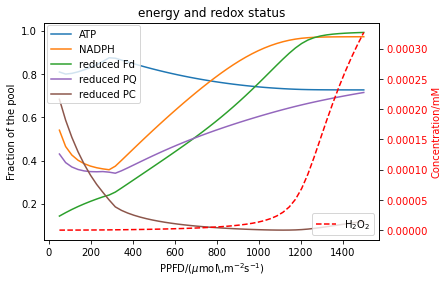

In [12]:
#analysis for kcyc and kNDH1 = 1
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

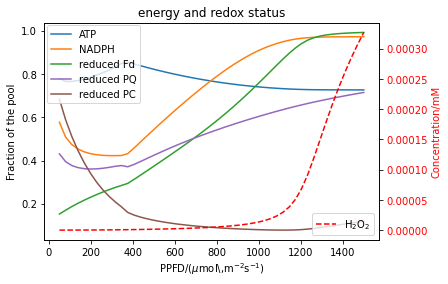

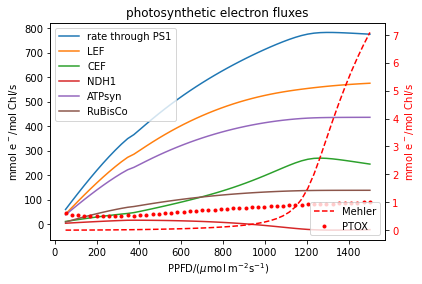

In [8]:
#analysis for kcyc and kNDH1 = 0.75
s.update_parameter("kNDH1",0.75)
s.update_parameter("kcyc",1)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

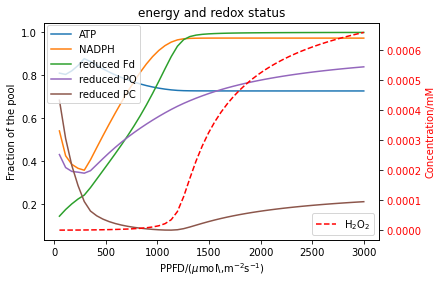

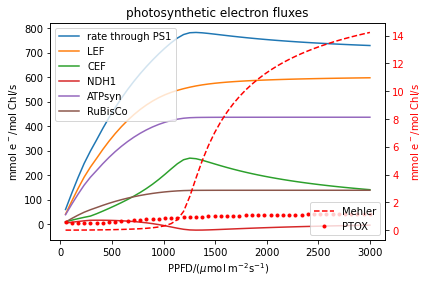

In [9]:
#analysis for kcyc and kNDH1 = 1 but pfd until 3000
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,3000,50))

fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

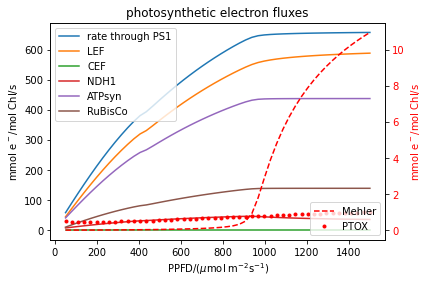

In [10]:
#Analysis for kcyc=0 and kNDH1=1
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",0)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))


fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

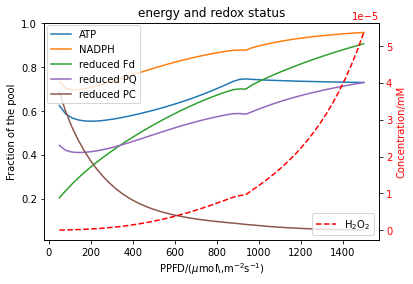

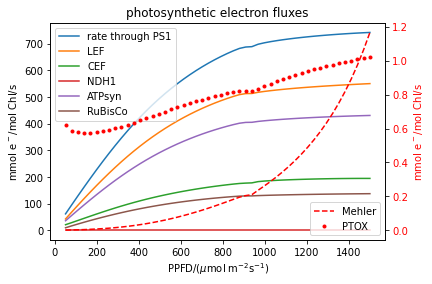

In [9]:
#Analyisis for kcyc=1 and kNDH1=0
s.update_parameter("kNDH1",0)
s.update_parameter("kcyc",1)

c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>)

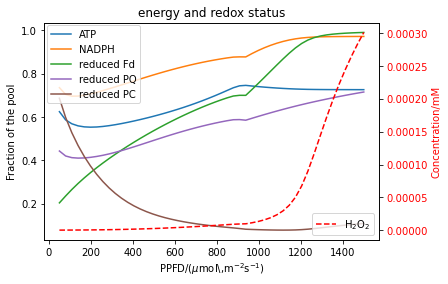

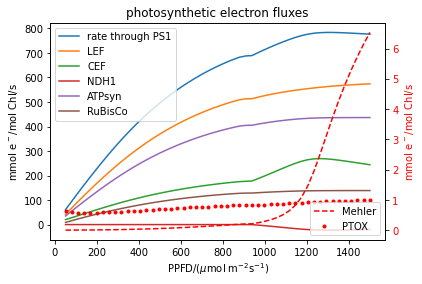

In [13]:
#analysis for kcyc=1 and kNDH1=0.0002
s.update_parameter("kNDH1",0.0002)
s.update_parameter("kcyc",1)

c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_ppfd_petc_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic proton fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:>)

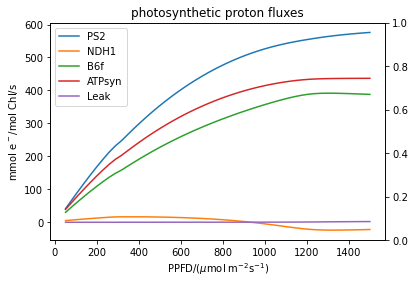

In [14]:
#proton flux scan 
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)

c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_proton_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic proton fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:>)

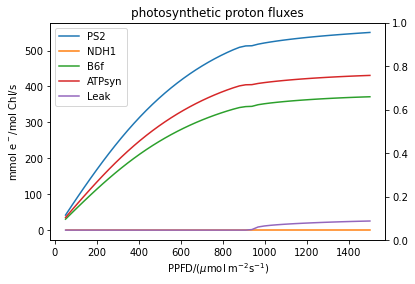

In [15]:
#proton flux scan 
s.update_parameter("kNDH1",0)
s.update_parameter("kcyc",1)

c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_proton_steady_state(v,ax1)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic proton fluxes'}, xlabel='PPFD/($\\mu$mol m$^{-2}$s$^{-1}$)', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:>)

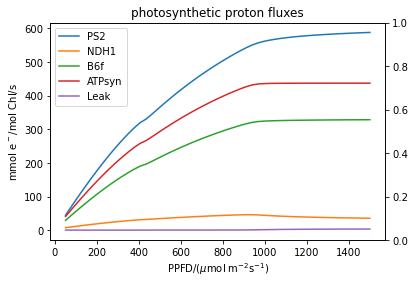

In [16]:
#proton flux scan 
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",0)

c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

fig, ax1= plt.subplots()
plot_ppfd_proton_steady_state(v,ax1)


kNDH1:   0%|          | 0/20 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>)

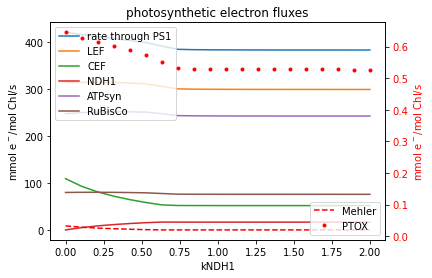

In [17]:
#kNDH1 parameter scan
s.update_parameter("kcyc",1)
s.update_parameter("kNDH1",1)
s.update_parameter("pfd", 400)
c,v = s.parameter_scan_with_fluxes("kNDH1",parameter_values=np.linspace(0,2,20))

fig, ax1= plt.subplots()
plot_kNDH1_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_kNDH1_petc_steady_state(v,ax1)

kNDH1:   0%|          | 0/20 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>)

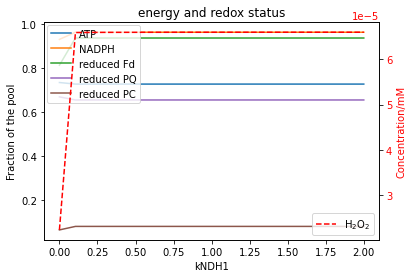

In [19]:
#kNDH1 parameter scan to approximate variation range
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd", 1200)
c,v = s.parameter_scan_with_fluxes("kNDH1",parameter_values=np.linspace(0,2,20))

fig, ax1= plt.subplots()
plot_kNDH1_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_kNDH1_petc_steady_state(v,ax1)

kNDH1:   0%|          | 0/20 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>)

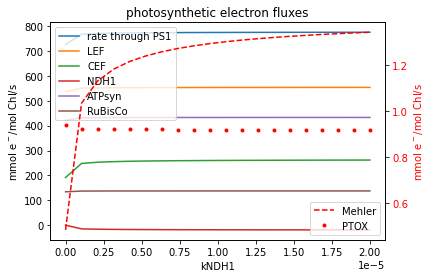

In [20]:
#kNDH1 parameter scan
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd", 1200)
c,v = s.parameter_scan_with_fluxes("kNDH1",parameter_values=np.linspace(0,0.00002,20))

fig, ax1= plt.subplots()
plot_kNDH1_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_kNDH1_petc_steady_state(v,ax1)

kcyc:   0%|          | 0/20 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>)

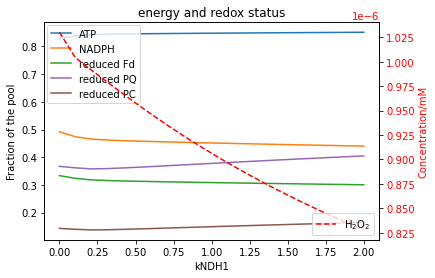

In [22]:
#kcyc parameter scan
s.update_parameter("kcyc",1)
s.update_parameter("kNDH1",1)
s.update_parameter("pfd", 400)
c,v = s.parameter_scan_with_fluxes("kcyc",parameter_values=np.linspace(0,2,20))

fig, ax1= plt.subplots()
plot_kNDH1_redox_steady_state(c,ax1)
fig, ax1 = plt.subplots()
plot_kNDH1_petc_steady_state(v,ax1)

kcyc:   0%|          | 0/20 [00:00<?, ?it/s]

(<AxesSubplot:title={'center':'photosynthetic electron fluxes'}, xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>,
 <AxesSubplot:xlabel='kNDH1', ylabel='mmol e$^-$/mol Chl/s'>)

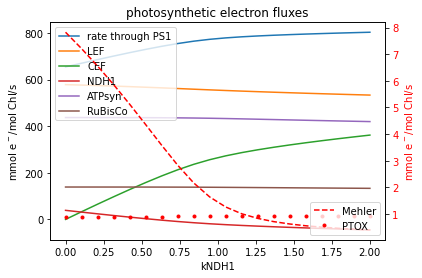

In [23]:
#kcyc parameter scan
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd", 1200)
c,v = s.parameter_scan_with_fluxes("kcyc",parameter_values=np.linspace(0,2,20))

fig, ax1= plt.subplots()
plot_kNDH1_redox_steady_state(c,ax1)
plt.xlabel("kcyc")
fig, ax1 = plt.subplots()
plot_kNDH1_petc_steady_state(v,ax1)

In [8]:
#pH without ndh1 active
s.update_parameter("kNDH1",0)
s.update_parameter("kcyc",1)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
h=c["pH"]



pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
#pH with ndh1 = 0.0002
s.update_parameter("kNDH1",0.0002)
s.update_parameter("kcyc",1)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
d=c["pH"]


pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
#pH with both active and Delta G NDH1 plotted
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))

plt.plot(np.linspace(50,1500,50), c["pH"],label="NDH1 active")
plt.plot(np.linspace(50,1500,50), d,label="kNDH1 = 0.0002")
plt.plot(np.linspace(50,1500,50),h, label="NDH1 inactive")
plt.xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
plt.ylabel("pH")
plt.legend(loc="lower left")


pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
#ph without kcyc and kNDH1 = 1
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",0)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
x=c["pH"]

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

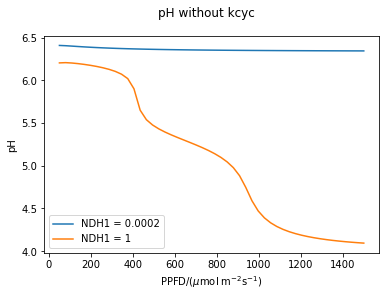

In [29]:
#ph without kcyc and kNDH1 = 0.0002
s.update_parameter("kNDH1",0.0002)
s.update_parameter("kcyc",0)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
g=c["pH"]

plt.plot(np.linspace(50,1500,50), g,label="NDH1 = 0.0002")
plt.plot(np.linspace(50,1500,50),x, label="NDH1 = 1")
plt.suptitle("pH without kcyc")
plt.xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
plt.ylabel("pH")
plt.legend(loc="lower left")

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

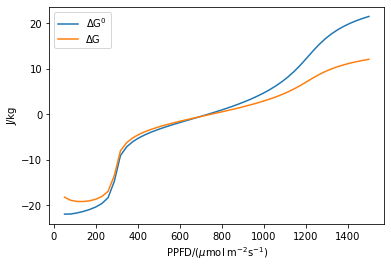

In [9]:
#Delta G and Delta G0 
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
plt.plot(np.linspace(50,1500,50),-m.get_parameter("RT")* np.log(c["Keq_NDH1"]), label="ΔG$^{0}$")
plt.plot(np.linspace(50,1500,50), -m.get_parameter("RT")* np.log(c["Keq_NDH1"])+ m.get_parameter("RT")* np.log(((c["Fd"]*c["PQred"])/(c["Fdred"]*c["PQ"]))), label="ΔG")
plt.xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
plt.ylabel("J/kg")
plt.legend(loc="upper left")

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

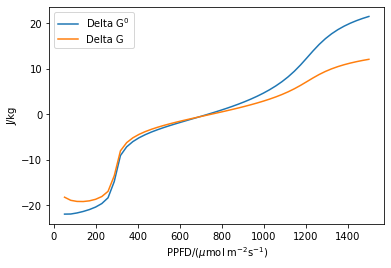

In [20]:
#Delta G and Delta G0 
s.update_parameter("kNDH1",1)
s.update_parameter("kcyc",1)
s.update_parameter("pfd",100)
c,v = s.parameter_scan_with_fluxes("pfd", parameter_values=np.linspace(50,1500,50))
plt.plot(np.linspace(50,1500,50),-m.get_parameter("RT")* np.log(c["Keq_NDH1"]), label="Delta G$^{0}$")
plt.plot(np.linspace(50,1500,50), -m.get_parameter("RT")* np.log(c["Keq_NDH1"]/((c["Fd"]*c["PQred"])/(c["Fdred"]*c["PQ"]))), label="Delta G")
plt.xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
plt.ylabel("J/kg")
plt.legend(loc="upper left")

Text(0.5, 0.98, 'NDH1 steady state flux depending on light condition')

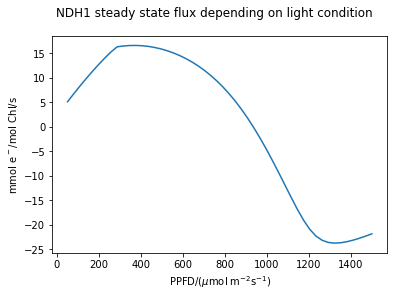

In [21]:
plt.plot(np.linspace(50,1500,50), v["vNDH1"])
plt.xlabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)")
plt.ylabel("mmol e$^-$/mol Chl/s")
plt.suptitle("NDH1 steady state flux depending on light condition")

In [11]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]

    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    return Fm, NPQ, tm, Fo, to



In [13]:
#NPQ

s1 = Simulator(get_model())
s1.initialise(y0)
s1.clear_results()
s1.update_parameter("kcyc",1)
s1.update_parameter("kNDH1",1)
pam_analysis(
    s1,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

In [15]:
c = s1.get_full_results_df()

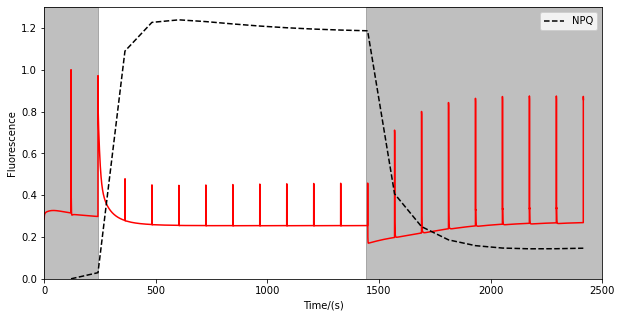

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"]/max(c["Fluo"]), color="red")
ax.plot(tm,NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0,2*120, color=(0,0,0,1/4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(xlim=(0,2500), ylim=(0,1.3), ylabel="Fluorescence", xlabel="Time/(s)")
ax.legend(loc="upper right")

plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [12]:
#NPQ
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc",0)
s1.update_parameter("kNDH1",0)
s1.clear_results()
pam_analysis(
    s1,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

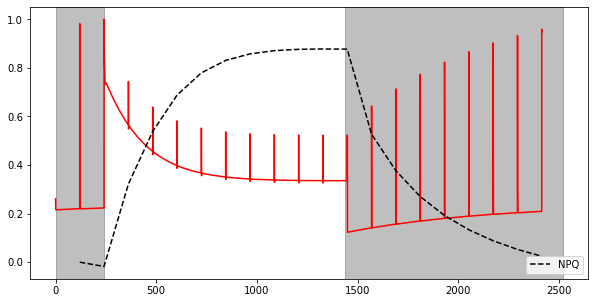

In [14]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
#ax.set(
#    ylim=(0, 1.1),
#    xlim=(0, 2500),
#    xlabel="Time/(s)",
#    ylabel="Fluorescence (normalised)",
#)
ax.legend(loc="lower right")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

In [45]:
#surface plot
def par_scan_osc_2d(
    s: Simulator,
    par_name1: str,
    par_values1: Iterable[float],
    par_name2: str,
    par_values2: Iterable[float],
    y0_loop: dict[str, float],
    t_end: float = 100_000,
) -> List[pd.DataFrame]:
    cmin = {}
    cmax = {}
    vmin = {}
    vmax = {}
    cavg = {}
    vavg = {}
    y0_outerloop = y0_loop
    for i, x1 in tqdm(enumerate(par_values1), total=len(par_values1)):
        cmin[x1] = {}
        cmax[x1] = {}
        vmin[x1] = {}
        vmax[x1] = {}
        cavg[x1] = {}
        vavg[x1] = {}
        s.update_parameter(par_name1, x1)
        for j, x2 in tqdm(enumerate(par_values2), total=len(par_values2)):
            if j == 0:
                s.initialise(y0_outerloop)
            else:
                s.initialise(y0_loop)

            s.update_parameter(par_name2, x2)
            t, y = s.simulate(t_end)
            if t is None:
                all_compounds = s.model.get_all_compounds()
                rate_names = s.model.get_rate_names()
                empty_cpds = pd.Series(
                    dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
                )
                empty_rates = pd.Series(
                    dict(zip(rate_names, np.full(len(rate_names), np.nan)))
                )
                cmin[x1][x2] = empty_cpds
                cmax[x1][x2] = empty_cpds
                cavg[x1][x2] = empty_cpds
                vmin[x1][x2] = empty_rates
                vmax[x1][x2] = empty_rates
                vavg[x1][x2] = empty_rates
            else:
                cmin[x1][x2], cmax[x1][x2], vmin[x1][x2], vmax[x1][x2] = get_minmax(
                    s, t_end
                )
                cavg[x1][x2], vavg[x1][x2] = get_avg(s, t_end)
                y0_loop = get_new_y0(s)

                if j == 0:
                    y0_outerloop = y0_loop

    multidfs = []
    mesh = np.meshgrid(par_values2, par_values1)
    colinds = [x.flatten() for x in mesh]
    for sol in (cmin, cmax, vmin, vmax, cavg, vavg):
        dfs = []
        for i in sol.keys():
            for j in sol[i].keys():
                dfs.append(sol[i][j])
        df3 = pd.DataFrame(
            data=np.array(dfs).T,
            index=dfs[0].index,
            columns=pd.MultiIndex.from_tuples(zip(*colinds)),
        )
        multidfs.append(df3)
    return multidfs

In [46]:
#surface plot for variation of kNDH1 and kcyc
m = get_model()
s = Simulator(m)
s.initialise(y0)


kNDH1_vals = np.linspace(0.1,2, 20)
kcyc_vals = np.linspace(0.05,2,20)

mdfs_cyc = par_scan_osc_2d(s, "kNDH1", kNDH1_vals, "kcyc", kcyc_vals, y0, t_end=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

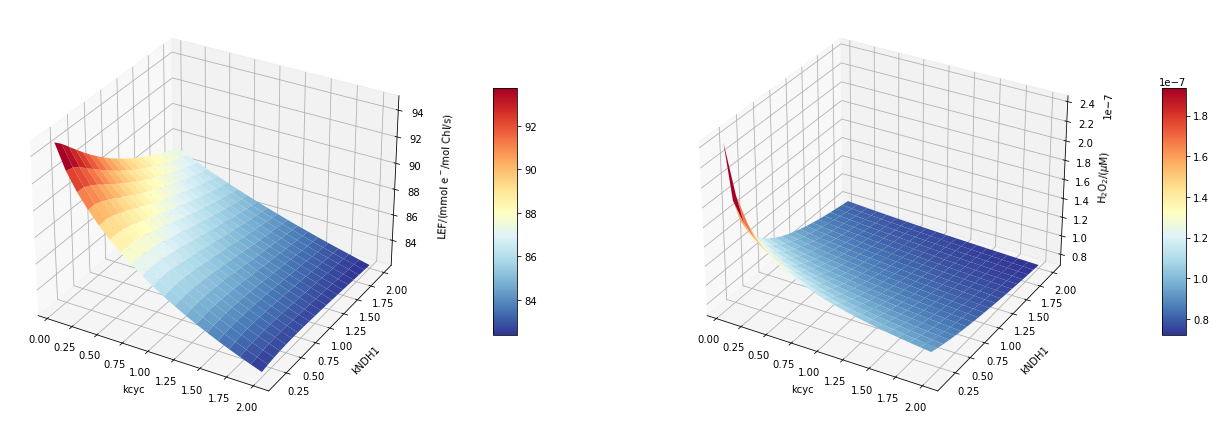

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={"projection": "3d"})

ax = ax1
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    2 * np.array(vavg.loc["vPS2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("LEF/(mmol e$^-$/mol Chl/s)", labelpad=10)
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)

ax = ax2
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    np.array(cavg.loc["H2O2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("H$_2$O$_2$/($\mu$M)")
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
fig.tight_layout()

In [48]:
#surface plot for variation of kNDH1 and kcyc
m = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameter("pfd", 400)

kNDH1_vals = np.linspace(0.1,2, 20)
kcyc_vals = np.linspace(0.05,2,20)

mdfs_cyc = par_scan_osc_2d(s, "kNDH1", kNDH1_vals, "kcyc", kcyc_vals, y0, t_end=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

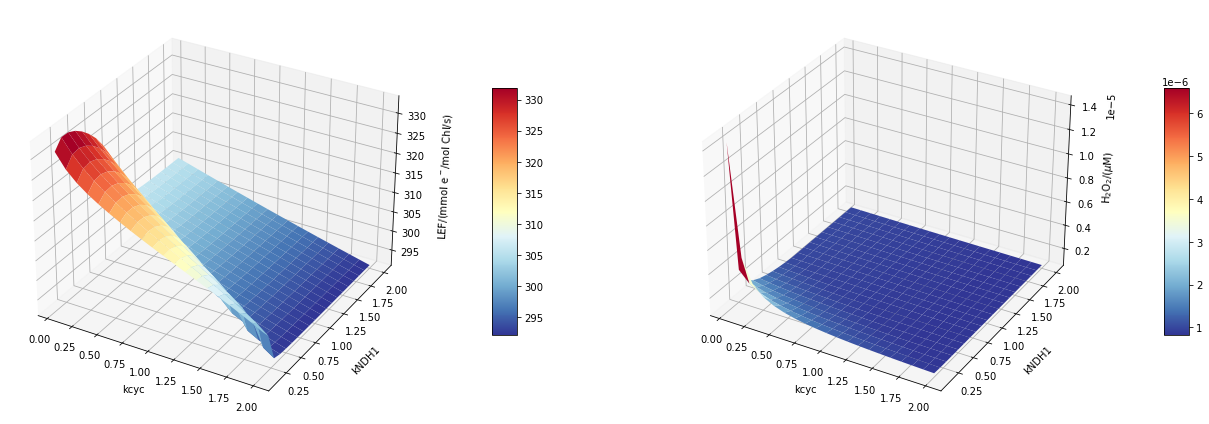

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={"projection": "3d"})

ax = ax1
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    2 * np.array(vavg.loc["vPS2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("LEF/(mmol e$^-$/mol Chl/s)", labelpad=10)
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)

ax = ax2
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    np.array(cavg.loc["H2O2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("H$_2$O$_2$/($\mu$M)")
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
fig.tight_layout()

In [50]:
#surface plot for variation of kNDH1 and kcyc
m = get_model()
s = Simulator(m)
s.initialise(y0)

s.update_parameter("pfd", 1100)

kNDH1_vals = np.linspace(0.1,2, 20)
kcyc_vals = np.linspace(0.05,2,20)

mdfs_cyc = par_scan_osc_2d(s, "kNDH1", kNDH1_vals, "kcyc", kcyc_vals, y0, t_end=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

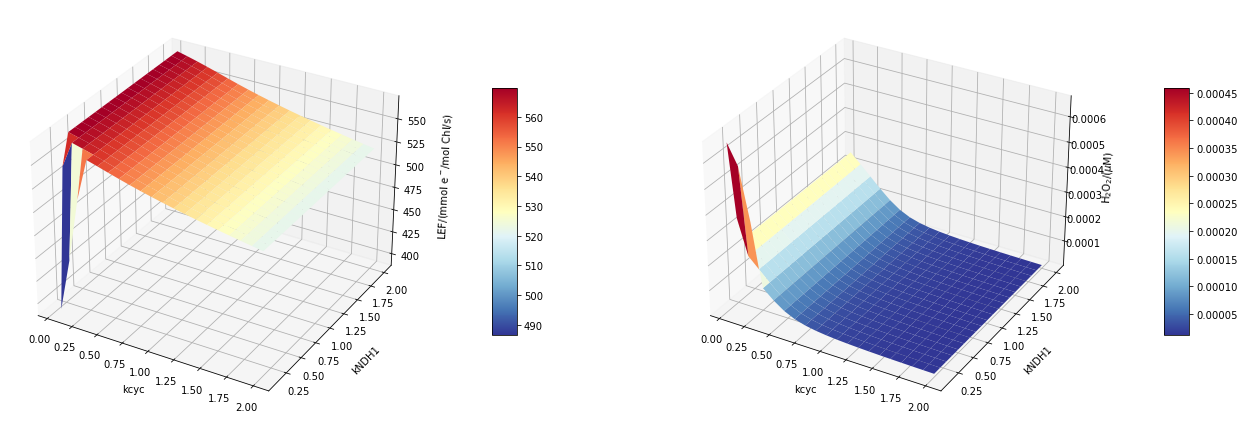

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={"projection": "3d"})

ax = ax1
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    2 * np.array(vavg.loc["vPS2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("LEF/(mmol e$^-$/mol Chl/s)", labelpad=10)
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)

ax = ax2
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, kNDH1_vals),
    np.array(cavg.loc["H2O2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("kcyc", labelpad=5)
ax.set_ylabel("kNDH1", labelpad=10)
ax.set_zlabel("H$_2$O$_2$/($\mu$M)")
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
fig.tight_layout()